In [50]:
%pylab ipympl
from scipy.integrate import odeint 
from scipy import integrate
import csv

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\jjder\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Free body diagram of the system. 
The shock cords are modeled as a spring, the parachute as a mass attached to a viscous damper with force proportional to the velocity squared, and the rockets as a mass. 

### Setting up the diffy Qs
 We can write two governing differential equations using our favourite equation: $ma-F=0$. $F$ is the sum of all forces on each body (in this case the force of the paracute drag, the force of the shock cords, and gravity) and $a$ is the acceleration of the mass (either the rocket or the parachutes).

<img src="FBD.png" width=500 />  

 We can split the two 2nd order equations into four 1st order equations so that odeint (the numerical solver) can solve them.

$$
\dot{x_p} = y_p,\\ \ \
\dot{x_r} = y_r,\\
\dot{y_r} = \frac{m_r g- k(x_r - x_p)}{m_r}, \\
\dot{y_p} = \frac{m_p g - c {y_p}^2 - k(x_p - x_r)}{m_p}, \\
$$

The constant $c$ is the value of viscous damping. It is easily derived from the drag equation:

$$
F_d=\frac{1}{2} \rho_{air} v^2 C_D A
$$

where $\rho_{air}$ is the density of air, $v^2$ is the velocity of the parachute, $C_D$ is the coeffecient of drag, and $A$ is the effective area. Combining the constant terms (we assume air density is constant during inflation), we are left with:

$$
F_d=cv^2
$$

where

$$
c=\frac{1}{2} \rho_{air} C_D A
$$

Now we can move on to setting up the simulation parameters.

### Setting up the solver (these are what you should edit for a sim)
First select the system properties:

In [20]:
# Postive direction is down. Vertical coordinate is x

mp   = 1.19	# [kg]      Mass of the parachute
ms   = 1.5	# [kg]			Mass of the shock cords
mr   = 13  	# [kg]      Mass of the rocket at deployment (minus the parachute and shock cord mass)
k    = 6700 # [N/m]     Spring constant of shock cords
rho  = 1.2	# [kg/m^3]	Air density at deployment
aeff = 6		# [m^2]			Effective (plan-form) area of the parachute (subtract any spill-hole area)
cd	 = 1.3	# []				Dimensionless coefficient of drag 

Then set the initial conditions:

In [21]:
xr_dot = 23.0   # [m/s] init velocity of rocket at when parachute inflates

Finally the duration to solve over:

In [22]:
t_start = 0.0   # [s]
t_end   = 0.2   # [s]
nt      = 500   # [] Number of data points to plot

Now let odeint work some magic... (You don't need to edit anything further)

In [23]:
# More constants for the sim
g   = 9.81      # [m/s^2]   Gravity
xp = 0.0        # [m]   init position is always zero
xr = 0.0        # [m]   init position is always zero
xp_dot = 0.0    # [m/s] init velocity of parachute (assumed to be roughly zero)

# Calculate the damping coefficent c from the drag equation
c = 0.5*rho*cd*aeff

# Calculate the effective mass of the parachute 1/3 effective mass for shock cord spring
mp_eff = mp + ms/3

# Time vector
t = linspace(t_start, t_end, nt)

# Initial conditon vector
y0=[xp, xr, xr_dot, xp_dot] 

# The function defining the right-hand sides (RHS) of the ODEs
def dy_dt(y, t, mp_eff, mr, c, k, g):
    
    # Initial values
    xp, xr, yr, yp = y 

    # Array of RHSs of differential equations
    dydt = [yp, yr, (mr*g - k*(xr-xp))/mr, (mp_eff*g - c*yp**2 - k*(xp-xr))/mp_eff]

    return dydt

# Solve the ODEs
sol = odeint(dy_dt, y0, t, args=(mp_eff,mr,c,k,g))  # This gives xp, xr, yr, yp

### Now onto the data analysis
First select the solution vectors from the solution and calculate the tension on the shock cords. This is just the difference between the position of the parachute and the rocket multiplied by the spring constant of the shock cords.

In [24]:
xp = sol[:,0] ; xr = sol[:,1] 
yr = sol[:,2] ; yp = sol[:,3]

tension = k*(xr-xp) # Tension in the shock cords [N]

Then we do some plotting.

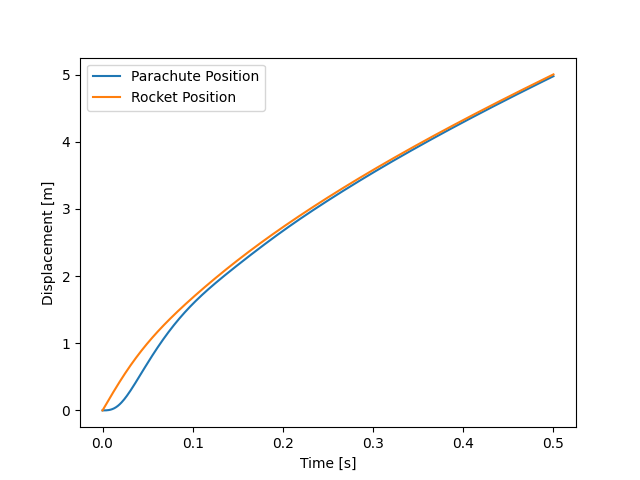

In [25]:
close(); figure()

plot(t, xp, label='Parachute Position')
plot(t, xr, label='Rocket Position')
xlabel('Time [s]')
ylabel('Displacement [m]')
savefig("disp-vs-t.png")

legend()

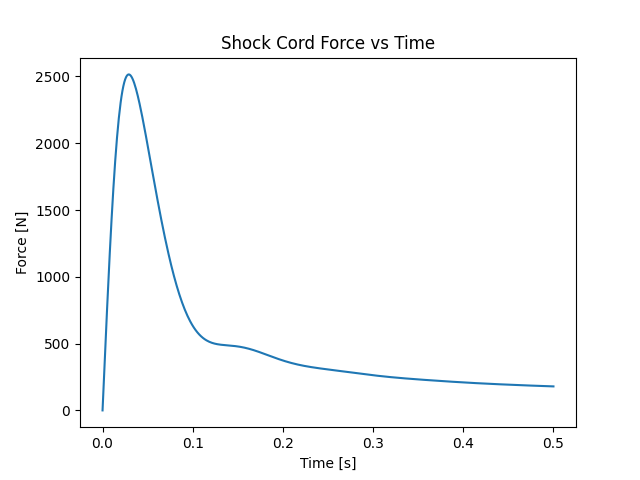

In [26]:
close(); figure()

plot(t, tension,label='Force on shock cords')
title('Shock Cord Force vs Time')
xlabel('Time [s]')
ylabel('Force [N]')
savefig('force-vs-time.png')

### Results for your Documentation
Copy and paste these results into your documentation. You do have documentation right? The graphs are also automatically saved as .png files in the same directory as this notebook.

In [53]:
print("Using the following solver parameters:\n")

print("Rocket Mass:\t\t\t\t %.2f" %mr,"\t[kg]")
print("Parachute Mass:\t\t\t\t %.2f" %mp,"\t[kg]")
print("Shock Cord Mass:\t\t\t %.2f" %ms,"\t[kg]")
print("Shock Cord k:\t\t\t\t %.0f" %k,"\t[N/m]")
print("Air Density:\t\t\t\t %.2f" %rho,"\t[kg/m^3]")
print("Drag Coefficient:\t\t\t %.2f" %cd,"\t[]")
print("Effective Area:\t\t\t\t %.2f" %aeff,"\t[m^2]")

print("Rocket velocity at inflation:\t\t %.2f" %xr_dot,"\t[m/s]")
print("Parachute velocity at inflation:\t %.2f" %xp_dot,"\t[m/s]")

print("\nProduced the following results:\n")
print("Parachute Damping Coeff:\t\t %.2f" %c, "\t[N/m/s]")
print("Maximum tension:\t\t\t %.0f" %max(tension), "\t[N]")
print("Maximum G load:\t\t\t\t %.2f" %((max(tension)/mr)/g), "\t[G]")

print("\nExported to load_data.csv")
print("First column is seconds, second is tension in N")

with open('load_data.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerows(zip(t, tension))

Using the following solver parameters:

Rocket Mass:				 13.00 	[kg]
Parachute Mass:				 1.19 	[kg]
Shock Cord Mass:			 1.50 	[kg]
Shock Cord k:				 6700 	[N/m]
Air Density:				 1.20 	[kg/m^3]
Drag Coefficient:			 1.30 	[]
Effective Area:				 6.00 	[m^2]
Rocket velocity at inflation:		 23.00 	[m/s]
Parachute velocity at inflation:	 0.00 	[m/s]

Produced the following results:

Parachute Damping Coeff:		 4.68 	[N/m/s]
Maximum tension:			 2515 	[N]
Maximum G load:				 19.72 	[G]

Exported to load_data.csv
First column is seconds, second is tension in N


### Comparing with Working Model 2D
Originally the team used the following Working Model 2d simulation which is outlined in the Xenia-1 final report.

<img src="WorkingModel.png" width=500 />  

This produced maximum loads that were approximately 5% higher than this solver. There were some slight differences in the sim setup due to the way that Working Model works so that may account for these differences.  

Since Working Model is clunky, old, closed source, and requires a license to use, this notebook was created as an open source alternative that is more extensible. I hope you enjoy - JJ.